### Installing Qiskit

#### Normal installation

In [1]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### GPU installation

In [2]:
# %pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu python-dotenv

### Libraries Importing


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
from sympy import *
import json
import time
import os

load_dotenv()
init_printing()
simulation_time = time.time()  # to calculate simulation time

In [3]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())

('CPU',)


#### Use GPU

In [4]:
# backend.set_options(device="GPU")

#### Use real quantum

In [5]:
# services = []

# for i in range(1, 6):
#     services.append(QiskitRuntimeService(
#         channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))

# # backend = service.backend("ibm_osaka") # for real quantum
# # backend = service.backend("ibm_kyoto") # for real quantum


### Problem Definition

In [6]:
conf = json.load(open("../conf_16.json", "r"))

In [6]:
N = conf["N"]  # Number of Teachers
M = conf["M"]  # Number of Classes
H = conf["H"]  # Number of hours in week

required_qubits = (M * N * H) + (M * H) + (N * H)
iterations = 0

random_seed = conf["random_seed"]
shots = conf["shots"] * 5
layers = 5

print("Requried Qubits: ", required_qubits)

Requried Qubits:  6


In [7]:
# T_i is binary string denoting the available hours for each i Teacher
# C_j is binary string denoting the available hours for each j Class

T = conf["T"]
C = conf["C"]

R = conf["R"]  # R_ij must be either 0 or 1

terms_count = 0
equations = []

### Formulation

#### Equations

In [8]:
for i in range(1, N + 1):
  for j in range(1, M + 1):
    temp = total = 0
    for h in range(1, H + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp - R[i-1][j-1])**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [9]:
for j in range(1, M + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for i in range(1, N + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"τ_{j}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [10]:
for i in range(1, N + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for j in range(1, M + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"λ_{i}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

#### Decodeing Equations

In [11]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []

  for term in terms:

    term = str(term)

    if term.startswith("τ"):
      j = int(term[2])
      h = int(term[3])
      output.append((h-1) * M + (j - 1))


    elif term.startswith("λ"):
      i = int(term[2])
      h = int(term[3])
      output.append((H * M) + ((h-1) * N + (i - 1)))

    elif term.startswith("f"):
      i = int(term[2])
      j = int(term[3])
      h = int(term[4])
      output.append((H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1))

  return output


In [12]:
prepared_equations = []
for equation in equations:
    temp = []
    for term in args(equation):
        if len(term.args) != 0:
            temp.append(prepare_equation(term))
    prepared_equations.append(temp)

prepared_equations

### Implementation

#### Objective Function

In [13]:
def f(i, j, h):
  return int(T[i-1][h-1] == C[j-1][h-1] == '1')

def tau_value(bit_string, j, h):
  return int(bit_string[(h-1) * M + (j - 1)])

def lambda_value(bit_string, i, h):
  return int(bit_string[(H * M) + ((h-1) * N + (i - 1))])

def f_value(bit_string, i, j, h):
  return int(bit_string[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])

In [14]:
def objective(bit_string):
  # since qiskit represent solution in least significant bit format
  bit_string = bit_string[::-1]
  cost = 0
  a = b = c = d = 0
  # equation a
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          for h in range(1, H + 1):
              if f(i, j, h) != f_value(bit_string, i, j, h):
                  cost += 1
                  a += 1

  # equation b
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          temp = 0
          for h in range(1, H + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp - R[i-1][j-1])**2
          b += (temp - R[i-1][j-1])**2

  # equation c
  for j in range(1, M + 1):
      for h in range(1, H + 1):
          temp = 0
          for i in range(1, N + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + tau_value(bit_string, j, h) - 1)**2
          c += (temp + tau_value(bit_string, j, h) - 1)**2

  # equation d
  for i in range(1, N + 1):
      for h in range(1, H + 1):
          temp = 0
          for j in range(1, M + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + lambda_value(bit_string, i, h) - 1)**2
          d += (temp + lambda_value(bit_string, i, h) - 1)**2

  return [cost, a, b, c, d]

#### Circuit

#### Draw circuit 

In [15]:
# qc = QuantumCircuit(required_qubits)

# for i in range(required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#     for term in equation:
#         theta = int(term[0])
#         locations = term[1]
#         if len(locations) == 1:  # Rz Gate
#             qc.rz(theta * -1 , locations[0])

#         elif len(locations) == 2:  # Rzz gate
#             qc.rz(theta * -0.5 , locations[0])
#             qc.rz(theta * -0.5 , locations[1])
#             qc.rzz(theta * 0.5 , locations[0], locations[1])

# for qubit in range(required_qubits - 1):
#     qc.rx(1, qubit)

# qc.draw("mpl")

In [16]:
def layers_gen(p, initial_value=1.0):
    return [initial_value] * p * 2


def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
        qc.h(i)
    
    for layer_index in range(n_layers):
        for equation in prepared_equations:
            for term in equation:
                theta = int(term[0])
                locations = term[1]

                if len(locations) == 1:  # Rz Gate
                    qc.rz(theta * -1 * alpha[layer_index], locations[0])

                elif len(locations) == 2:  # Rzz gate
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[0])
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[1])
                    qc.rzz(theta * 0.5 * alpha[layer_index], locations[0], locations[1])

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index], qubit)

    qc.measure_all()

    return qc

In [17]:
total = [0] * 4


def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b, c, d = objective(bit_string)
        total[0] += a
        total[1] += b
        total[2] += c
        total[3] += d
        avg += obj * count
        sum_count += count
    return avg/sum_count


def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc, backend, optimization_level=3,
                       seed_transpiler=random_seed)

        counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [28]:
from scipy.optimize import minimize
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA')
minimization_time = time.time() - start_time

res

4.8044921875
4.4654296875
4.5236328125
4.1630859375
3.2423828125
3.6130859375
3.820703125
3.0810546875
2.8244140625
3.1193359375
2.30703125
4.58828125
1.99921875
2.30859375
2.1470703125
3.051953125
3.42890625
2.0216796875
2.299609375
2.0642578125
2.4486328125
2.012890625
3.4421875
1.9630859375
1.905859375
2.37265625
1.803125
1.8375
1.866015625
1.7970703125
1.771484375
2.119921875
1.8708984375
1.7583984375
1.6357421875
1.7083984375
1.601953125
1.5142578125
1.453515625
1.490234375
1.468359375
1.5595703125
1.473828125
1.446875
1.45625
1.533203125
1.3970703125
1.398828125
1.4130859375
1.402734375
1.38671875
1.391796875
1.3814453125
1.3822265625
1.3927734375
1.3884765625
1.362109375
1.3595703125
1.37109375
1.3384765625
1.374609375
1.3517578125
1.3294921875
1.32890625
1.346875
1.3314453125
1.3435546875
1.3291015625
1.357421875
1.328125
1.3298828125
1.32578125
1.3263671875
1.338671875
1.3232421875
1.3193359375
1.327734375
1.3203125
1.321875
1.32734375
1.31328125
1.321484375
1.312890625
1.3164

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.2453125
       x: [ 1.589e+00  3.770e-01  1.217e+00  8.456e-01  3.467e-01
            7.433e-01  1.609e+00  1.376e+00 -1.419e-01  1.394e+00]
    nfev: 191
   maxcv: 0.0

In [19]:
print("a:", total[0])
print("b:", total[1])
print("c:", total[2])
print("d:", total[3])

a: 10142
b: 5070
c: 7374
d: 7368


### Results

25
-----------------
BINGO
011010
2030
-----------------
Solution 100101 cost: 2 count 2106
Solution 011010 cost: 0 count 2030
Solution 110000 cost: 2 count 394
Solution 001111 cost: 2 count 355
Solution 110100 cost: 3 count 23
Solution 110001 cost: 3 count 22
Solution 011110 cost: 1 count 22
Solution 100001 cost: 3 count 19
Solution 001011 cost: 3 count 19
Solution 011011 cost: 1 count 19


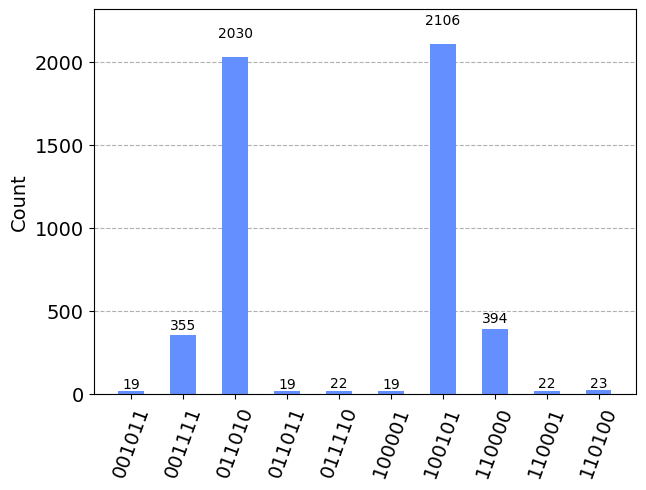

In [20]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed,
                     shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
counts_cost = dict(
    sorted(counts.items(), key=lambda item: item[1], reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
    if objective(key)[0] == 0:
        print("-----------------")
        print("BINGO")
        print(key)
        print(counts[key])
        print("-----------------")

for key in binary[:10]:
    print("Solution", key, "cost:", objective(key)[0], "count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [21]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["M"] = M
counts["N"] = N
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 011010 cost: 0 count 2030


In [22]:
file = open(f"../json/{H}_{M}_{N}_{shots}_{layers}_simulation.json", "w")
file.write(json.dumps(counts))
file.flush()

In [23]:
counts["execution_time"]

In [24]:
minimization_time